# Прекод

## Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Загрузим необходимые библиотеки

In [ ]:
%%capture
!pip install transformers
!pip install nltk
!pip install torch

In [ ]:
# для работы с данными
import pandas as pd
import math
import numpy as np
from collections import Counter

# предобработка и поиск запретов
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# векторизация и загрузка изображений
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18
from tqdm.notebook import tqdm

# векторизация текста
import transformers
from transformers import BertTokenizer, TFBertModel

# визуализация
import matplotlib.pyplot as plt

# моделирование
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import mean_squared_error

# нейросетевое моделирование
import torch
from torch import nn
from torch.nn import Sequential
from torch.optim import Adam


import os
# подключимся к диску
import os
from google.colab import drive
drive.mount('/content/drive')


import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')
nltk.download('punkt')

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# инициализируем путь к данным
main_path = "/content/drive/MyDrive/Yandex Practicum NLP+CV/data/"

# Исследовательский анализ данных

Разделим EDA на 3 главные составляющие:
    
    1) Загрузка и знакомтсво с данными;
    2) предобработка
    3) Объединим наши данные и получим дата-фрейм для обучения.

## Загрузим данные


In [ ]:
# загрузим тренировочные данные, а также данные с экспертной оценкой и данные с оценкой краудфандинговых
crowd_annotations = pd.read_csv(main_path + 'CrowdAnnotations.tsv', sep='\t',
                                header=None, names=['image', 'query_id', 'positive_share', 'positive_amount', 'negative_amount'])

expert_annotations = pd.read_csv(main_path + 'ExpertAnnotations.tsv', sep='\t',
                                 header=None, names=['image', 'query_id', 'first_expert', 'second_expert', 'third_expert'])

df_train = pd.read_csv(main_path + 'train_dataset.csv')

In [ ]:
print('Данные полученные в результате экспертной оценки: \n')

print(expert_annotations.info(), '\n')
expert_annotations.head(5)

Данные полученные в результате экспертной оценки: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None 



image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  
0              1             1  
1              1             2  
2              1             2  
3              2             2  
4              1             2

In [ ]:
print('Данные полученные в результате краудсорсинга:\n')

print(crowd_annotations.info(), '\n')
crowd_annotations.head(5)

Данные полученные в результате краудсорсинга:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   positive_share   47830 non-null  float64
 3   positive_amount  47830 non-null  int64  
 4   negative_amount  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None 



image                     query_id  positive_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2             0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2             0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2             0.0   

   positive_amount  negative_amount  
0                3                0  
1                0                3  
2                0                3  
3                0                3  
4                0                3

In [ ]:
print('Данные для обучения:\n')
df_train.info()

df_train.head(5)

Данные для обучения:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

**В данных по краудсорсингу, можно заметить, что используется доля позитивных ответов. Это мы будем принимать как целевую переменную по в этом датафрейме. Этот дата-фрейм мы не будем предобрабатывать**

**В дата-фрейме с экспертными оценками содержаться разные голоса экспертов, о принаделжности картинки к описанию. Эксперты оценивают, насколько описание соотвествует картинки по 4 бальной шкале, где:**
    
    1- изображение и запрос совершенно не соответствуют друг другу;
    2- запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
    3- запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
    4- запрос и текст соответствуют полностью.

*Соответственно, мы можем провести частотный анализ ответов экспертов. Если мнения экспертов разделились, то мы такие данные отбросим, в остальном случае - выберем большинство. Будем использовать принцип, объяснённый в задаче проекта.*

Важно также учитывать разницу в структурах данных. Мы можем наблюдать, что у нас в карудсорсинговых данных описания представлено до 5 описаний к каждой картинке. Понятно, что когда мы будем мёржить данные - размерность значительно снизится.

## Предобработка данных

*Создадим метод, который будет оценивать частотность ответов экспертов.*

In [ ]:
def frequent(numbers):
    if len(set(numbers)) == 3:
        return -1
    else:
        counter = Counter(numbers)
        return max(counter, key=counter.get)

# Применяем функцию к последним трём столбцам датафрейма
expert_annotations['most_frequent'] = (expert_annotations[['first_expert', 'second_expert', 'third_expert']]
                                       .apply(lambda row: frequent(row), axis=1))

*Посмотрим, как выполнился анализ частотности:*

In [ ]:
expert_annotations.tail(15)

image                     query_id  first_expert  \
5807  979383193_0a542a059d.jpg  1962729184_6996e128e7.jpg#2             2   
5808  979383193_0a542a059d.jpg  3079787482_0757e9d167.jpg#2             2   
5809  979383193_0a542a059d.jpg  3108197858_441ff38565.jpg#2             1   
5810  979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2             2   
5811  979383193_0a542a059d.jpg  3468694409_a51571d621.jpg#2             1   
5812  979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2             1   
5813  979383193_0a542a059d.jpg  3585598356_8ce815bbb9.jpg#2             1   
5814  997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2             1   
5815  997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2             1   
5816  997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2             1   
5817  997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2             1   
5818  997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2             1   
5819  997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2             1   
5820  997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2             1   
5821  997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2             3   

      second_expert  third_expert  most_frequent  
5807              2             2              2  
5808              3             3              3  
5809              2             3             -1  
5810              2             2              2  
5811              1             1              1  
5812              2             2              2  
5813              1             1              1  
5814              1             2              1  
5815              1             2              1  
5816              1             1              1  
5817              1             1              1  
5818              1             1              1  
5819              1             2              1  
5820              1             1              1  
5821              3             3              3

*Всё выполнилось корректно, можно удалять лишние строки*

In [ ]:
print('Размерность датафрейма до:', expert_annotations.shape)
expert_annotations = expert_annotations[expert_annotations['most_frequent'] != -1]
print('Размерность датафрейма после:', expert_annotations.shape)

Размерность датафрейма до: (5822, 6)
Размерность датафрейма после: (5696, 6)


*Мы потеряли совсем незначительно кол-во примеров. Что может говорить о том, что эксперты сходятся в едином мнение.*
*Теперь мы переведём ответы экспертов в вероятности того, что картинка соотвествует описанию:*

In [ ]:
expert_annotations['positive_probability'] = expert_annotations['most_frequent'].apply(lambda x: (x-1)/3)

## Соединим данные

*Теперь соединим все данные в единый дата-фрейм, чтобы получить данные для обучения. Нашей задаче будет составить датафрейм c картинками, описанием и вероятностью соотвествия.*

In [ ]:
df_train = df_train.merge(crowd_annotations, how='left').merge(expert_annotations, how='left')

In [ ]:
def construct_probability(row: pd.Series) -> float:
    """
    Вычисляет вероятность на основе данных о доле краудсорсинговых положительных отзывов о (crowd_p)
    и вероятности положительных отзывов от экспертов (expert_p). Если значение crowd_p отсутствует
    (NaN), функция использует значение expert_p и наоборот. Если оба значения отсутствуют, возвращает NaN.

    Параметры:
    row (pd.Series): Ряд (запись) из Дата-фрейма, содержащий 'positive_share' и 'positive_probability'.

    Возвращает:
    float: Вычисленная вероятность на основе краудсорсинговых и экспертных данных.
    """
    crowd_p = row['positive_share']
    expert_p = row['positive_probability']
    if math.isnan(crowd_p):
        return expert_p
    elif math.isnan(expert_p):
        return crowd_p
    else:
        return expert_p * 0.7 + crowd_p * 0.3

# применим функцию и оставим только целевые данные
df_train['probability'] = df_train.apply(construct_probability, axis=1)
df_train = df_train[['image', 'query_id', 'query_text', 'probability']]

In [ ]:
df_train = df_train[df_train['probability'].notna()]

In [ ]:
display(df_train.tail(5))

print('Размер итогового дата-фрейма:', df_train.shape)

image                     query_id  \
5817  757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818  799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                        query_text  probability  
5817    A man in an ampitheater talking to a boy .     0.333333  
5818     a old man walks down the uncrowded road .     0.000000  
5819  A dog stands on the side of a grassy cliff .     0.333333  
5820                  A blurry photo of two dogs .     0.466667  
5821                   A man rows his boat below .     0.000000

Размер итогового дата-фрейма: (5767, 4)


# Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

*Поскольку у нас нет возможности использовать блокировку, наиболее оптимальным и верным решением для выполнения поставленной задачи, будет откинуть все те изображения, которые содержат изображения с деьтми. Для этого, нужно:*
    
    1) Создать список всех слов, которые могут противоречить законодательству;
    2) Удалить все картинки из дата-фрейма для обучения, где в описание встречаются запретные слова.

*Во втором пункте, если хотя бы один человек, при каких-то обстоятельсвах оценил, что есть вероятность, что на фото ребёнок, такая пара будет отброшена из всего датасета. Пороговая вероятность 0.2*

In [ ]:
# Создадим объект лемматизации
lemmatizer = WordNetLemmatizer()

def get_synonyms(word):
    """
    Получает синонимы для заданного слова с использованием WordNet.

    Args:
        word (str): Слово, для которого необходимо получить синонимы.

    Returns:
        set: Множество синонимов слова.
    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

# Сформируем список запрещенных слов и их синонимов
restricted_words = set()
restricted_words.update(get_synonyms("child"))
restricted_words.update(get_synonyms("girl"))
restricted_words.update(get_synonyms("boy"))
restricted_words.update(get_synonyms("boy"))


def filter_text(text):
    """
    Фильтрует текст, исключая строки, содержащие запрещенные слова и их синонимы.

    Args:
        text (str): Текст для фильтрации.

    Returns:
        bool: True, если текст содержит запрещенные слова, иначе False.
    """
    words = word_tokenize(text.lower())
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return any(word in restricted_words for word in lemmatized_words)

# Применяем функцию фильтрации к столбцу 'query_text' в DataFrame
df_train['not_legal'] = df_train['query_text'].apply(filter_text)

# сначала отберём список изображений, которые более чем с 0.2 вероятностью соотвествуют текстовому описанию, а в тексте есть "запрещенные слова".
not_legal_imagenations = df_train[(df_train['not_legal'] == True) & (df_train['probability'] > 0.2)].image.unique()
print('Всего фото с детьми:', len(not_legal_imagenations))

Всего фото с детьми: 335


In [ ]:
print('Размер целевого дата-фрейма до очистки от изображений детей:', df_train.shape)

# отфильтруем дата-фрейм оставив только подходящие для аналитики картинки
df_train = df_train[~df_train['image'].isin(not_legal_imagenations)]

# теперь исключим и описания, содеражщие запрещённые слова
df_train = df_train[df_train['not_legal'] != True]

df_train.reset_index(drop=True, inplace=True)

print('Размер целевого дата-фрейма после очистки от изображений детей:', df_train.shape)

Размер целевого дата-фрейма до очистки от изображений детей: (5767, 5)
Размер целевого дата-фрейма после очистки от изображений детей: (3096, 5)


**Все потенциально запрещённые пары (картинки наиболее вероятным содержанием детей на фото и описания, имеющие запрещенные слова).**

*Выведем несколько изображений, которые на 100% совпадают и на 0% совпадают, а также те, которые в диапазоне от 0.3 до 0.6 и посмотирм, как это выглядит*

Полностью правдивые:


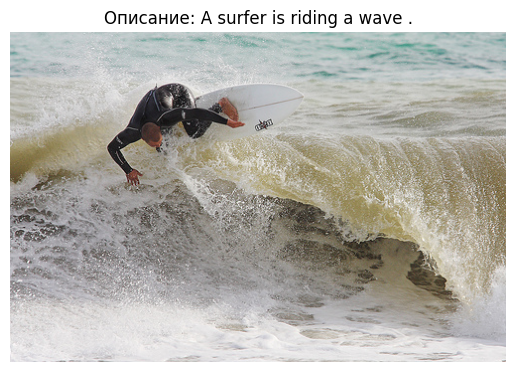

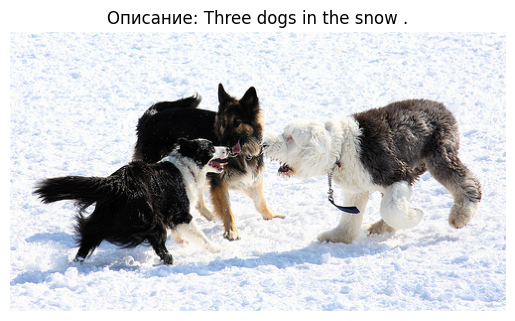

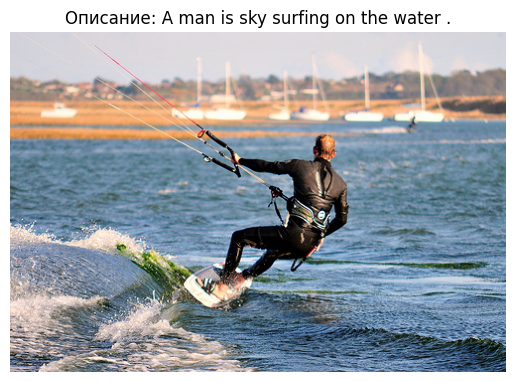

Сомнительные:


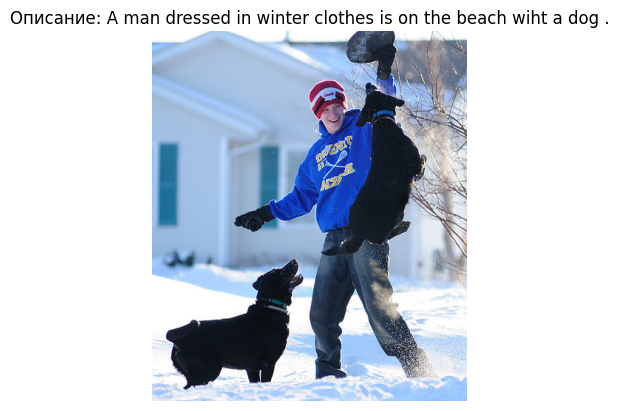

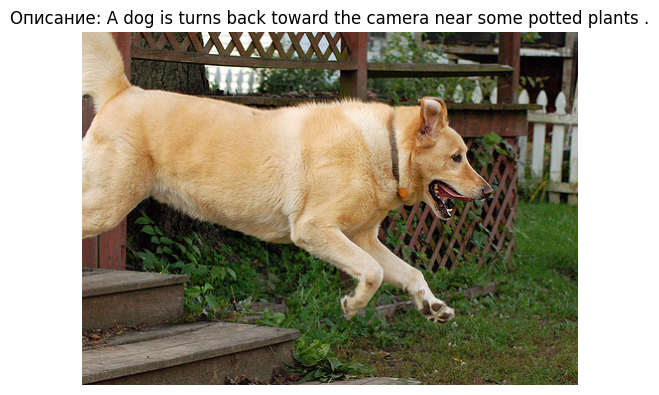

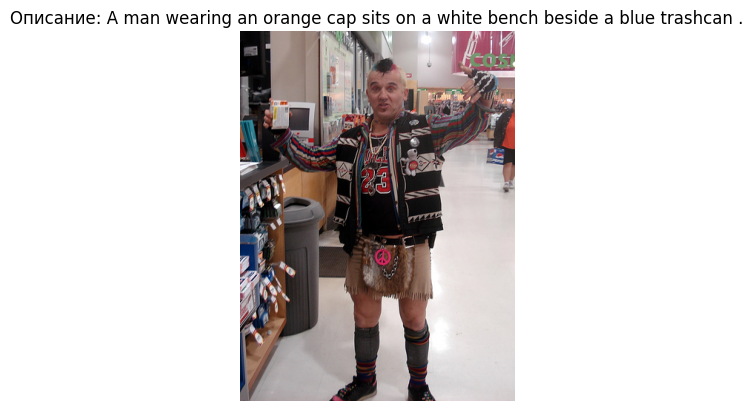

Полностью не правдивые:


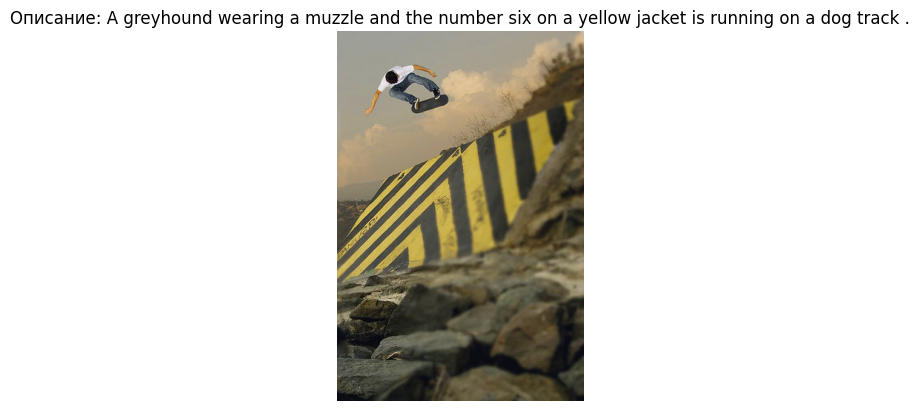

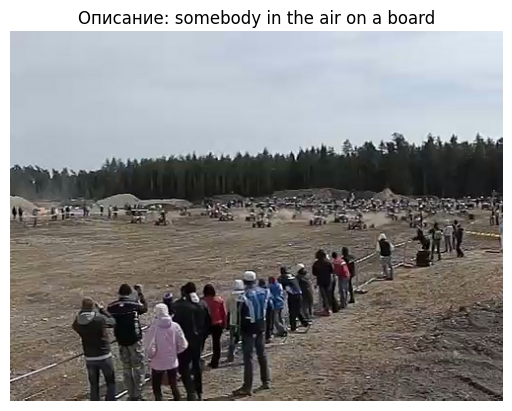

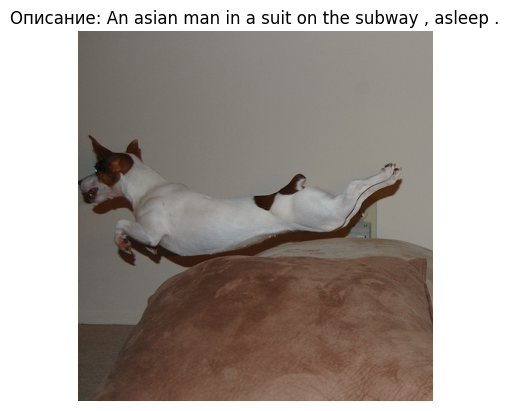

In [ ]:
np.random.seed(42)

def display_images(data, title):

    # инциализируем загрузчик
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

    for index, values in enumerate(data.values):

        image_path = values[1]
        description = values[-3]
        img = Image.open(os.path.join(main_path, 'train_images/', image_path))
        img_tensor = transform(img)
        plt.imshow(img)
        plt.title(f'Описание: {description}')
        plt.axis('off')
        plt.show()

full_true = df_train[df_train['probability'] == 1].sample(3).reset_index()
average_prob = df_train[(df_train['probability'] >= 0.3) & (df_train['probability'] <= 0.6)].sample(3).reset_index()
full_false = df_train[df_train['probability'] == 0].sample(3).reset_index()

print('Полностью правдивые:')
display_images(full_true, 'Полностью правдивые')

print('Сомнительные:')
display_images(average_prob, 'Сомнительные')

print('Полностью не правдивые:')
display_images(full_false, 'Полностью не правдивые')


*Да. предобработка сделана правильно! Инутитивно прослеживается логика, между текстом, вероятностью и картинкой. А изображения с детьми, вроде как в выборку не попали*

#  Векторизация изображений

**Реализуем resnet:**

In [ ]:
resnet = resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


vectorized_images = []

for i in tqdm(range(len(df_train.image)), leave=False):
    img_path = os.path.join(main_path, 'train_images/', df_train.loc[i]['image'])
    img = Image.open(img_path).convert('RGB')
    image_tensor = transformer(img).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    vectorized_images.append(output_tensor)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.4MB/s]


  0%|          | 0/3096 [00:00<?, ?it/s]

In [ ]:
vectorized_images_arr = torch.stack(vectorized_images)

# Печать размера полученного векторизированного массива
print("Размер векторизированных изображений:", vectorized_images_arr.size())

Размер векторизированных изображений: torch.Size([3096, 512])


# Векторизация текстов

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = df_train['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

padded = np.array([i + [0]*(200 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

# инициализируем нашу берт модель
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

batch_size = 4
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())


  0%|          | 0/774 [00:00<?, ?it/s]

In [ ]:
# создадим набор признаков
vectorized_text = np.concatenate(embeddings)

# Печать размера полученного векторизированного массива
print("Размер векторизированных изображений:", vectorized_text.shape)

Размер векторизированных изображений: (3096, 768)


# Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
# преобразуем массив
images_array = vectorized_images_arr.numpy()

In [ ]:
# Объединение данных
X = np.concatenate([images_array, vectorized_text], axis=1)
print(X.shape)

(3096, 1280)


# Обучение модели предсказания соответствия


In [ ]:
# Создание GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)

# Разделение данных на обучающий и валидационный наборы
train_indices, valid_indices = next(gss.split(X=df_train.drop(columns=['probability', 'image']), y=df_train['probability'], groups=df_train['image']))
X_train, X_valid = X[train_indices], X[valid_indices]
y_train, y_valid = df_train.iloc[train_indices, -2].values, df_train.iloc[valid_indices, -2].values

In [ ]:
print('Размер данных для обучения:', X_train.shape, y_train.shape)
print('Размер данных для валидации:', X_valid.shape, y_valid.shape)

Размер данных для обучения: (2470, 1280) (2470,)
Размер данных для валидации: (626, 1280) (626,)


В качестве целевой метрики будем использовать MSE. Поскольку наша задача является задачей соотвествия (image-text matching), и нам, надо предсказать вероятность того, что вектор и изоображение соотвествуют друг другу. В контексте данной задачи, у целевой переменной нет статистических выбросов, а наша задача найти минимальную ошибку.

In [ ]:
# также, учитывая, что данные пришли из разных источников, имеет смысла преобразить их с помощью Scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

*Для начала построим BaseLine модель, в виде модели предсказывающей константное значение. Предположим, что наша модель предсказывает 2 значения, медиану и среднее. И посмотрим на качество.*

In [ ]:
median_preds = [np.median(y_train) for _ in range(len(y_valid))]
mean_preds = [np.mean(y_train) for _ in range(len(y_valid))]

print('MSE для медианы:', round(mean_squared_error(median_preds, y_valid), 3))
print('MSE для среднего:', round(mean_squared_error(mean_preds, y_valid), 3))

MSE для медианы: 0.127
MSE для среднего: 0.077


*В целом, теперь мы понимаем, что наша цель минимизировать ошибку сильнее, чем это происходит в случае подстановки медианы и среднего. Для начала порпобуем реализовать линейную регрессию.*

In [ ]:
# Инициализация и обучение линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказание на валидационных данных
linear_pred = linear_model.predict(X_valid)
linear_pred = np.clip(linear_pred, 0, 1)

# Оценка модели с использованием MSE
mse_linear = mean_squared_error(y_valid, linear_pred)
print(f'MSE для линейной регрессии: {round(mse_linear, 2)}')

MSE для линейной регрессии: 0.3


*Линейной регрессии её результаты хуже, чем у базовой модели. Такие результаты неудовлетворительны для нашей задачи. Вероятно, линейная регрессия слишком сложная модель. Попробуем Ridge и Lasso регрессии, с подбором оптимальных гиперпараметров.*

In [ ]:
ridge_params = {'alpha': [0.001, 0.01, 0.003, 0.005]}
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)

# получим лучшие параметры Ridge регрессии
best_ridge_alpha = ridge_grid.best_params_['alpha']

ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)

# Предсказание на валидационных данных для Ridge регрессии
ridge_pred = ridge_model.predict(X_valid)
ridge_pred = np.clip(ridge_pred, 0, 1)

In [ ]:
lasso_params = {'alpha': [0.001, 0.01, 0.003, 0.005]}
lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

# Получение лучших параметров Lasso регрессии
best_lasso_alpha = lasso_grid.best_params_['alpha']

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)

# Предсказание на валидационных данных для Lasso регрессии
lasso_pred = lasso_model.predict(X_valid)
lasso_pred = np.clip(lasso_pred, 0, 1)

In [ ]:
# Оценка Ridge и Lasso
mse_ridge = mean_squared_error(y_valid, ridge_pred)
mse_lasso = mean_squared_error(y_valid, lasso_pred)

print(f'MSE для Ridge регрессии: {round(mse_ridge, 2)}')
print(f'MSE для Lasso регрессии: {round(mse_lasso, 2)}')

MSE для Ridge регрессии: 0.29
MSE для Lasso регрессии: 0.07


*Ridge и Lasso - регрессии, уже показывают куда более эффективные результаты. Наиболее эффективной оказалась Lasso регрессия. Удалось снизить метрику MSE до 0.07, что уже лучше, чем у базовой модели. Тем не менее, можно ещё сильнее сократить ошибку.*

**Попробуем реализовать базовую нейросеть, добавим также L1-регуляризацию, поскольку она эффективно себя показала на предыдущих этапах. Попробуем для **

In [ ]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_valid)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_valid)

*Реализуем классы для обучения сети:*

In [ ]:
# Создание модели
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(X_train.shape[1], 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

*Обучение:*

  0%|          | 0/1500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06792593002319336


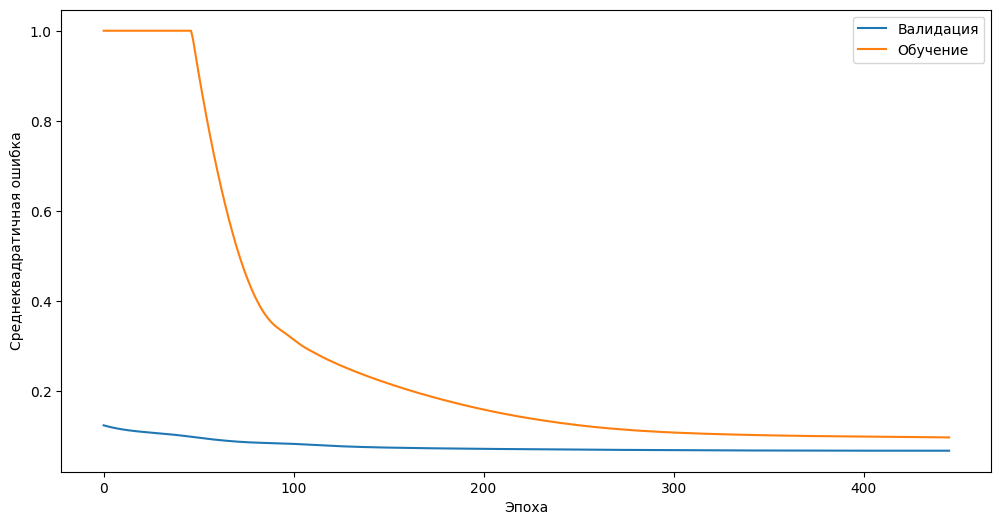

In [ ]:
net = Net()
optimizer = Adam(net.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=20, delta=0.00001)

num_epochs = 1500

losses = list()
mses = list()

# Добавление EarlyStopping в цикл обучения
for epoch in tqdm(range(num_epochs)):
    net.train()
    optimizer.zero_grad()

    preds = net.forward(X_train_tensor).flatten()

    loss_value = loss_fn(preds, y_train_tensor)

    l1_weight = 0.001

    # Compute L1 and L2 loss component
    parameters = []
    for parameter in net.parameters():
        parameters.append(parameter.view(-1))

    l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
    loss_value += l1

    losses.append(float(loss_value.detach().numpy()))

    loss_value.backward()

    optimizer.step()

    net.eval()
    val_preds = net.forward(X_val_tensor)
    mse = mean_squared_error(val_preds.flatten().detach().numpy(), y_val_tensor.numpy())
    mses.append(mse)

    early_stopping(mse)

    if early_stopping.early_stop:
        print(f"Early stopping, MSE: {mse}")
        break

plt.figure(figsize=(12, 6))

# для удобной визуализации
plt.plot(np.clip(mses, 0, 1), label='Валидация')
plt.plot(np.clip(losses, 0, 1), label='Обучение')

plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

**Получилось достичь MSE в размере 0.068. Что уже гораздо лучше. Стоит реализовать подбор гиперпараметров. Для этого реализуем новые классы:**.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_layers, hidden_layer_size, dropout, l1_alpha, learning_rate):
        super(Net, self).__init__()

        layers = [nn.Linear(X_train.shape[1], hidden_layer_size), nn.ReLU()]

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

        # Output layer
        layers.append(nn.Linear(hidden_layer_size, 1))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)
        self.l1_alpha = l1_alpha
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.layers(x)

    def compute_l1_loss(self):
        if self.l1_alpha is not None:
            return torch.abs(self.l1_alpha * self.layers[0].weight).sum()
        else:
            return torch.tensor(0.0, requires_grad=True)



# Определение функции обучения
def train_model(X_train, y_train, X_val, y_val, num_epochs, model_params):
    net = Net(**model_params)
    optimizer = Adam(net.parameters(), lr=model_params['learning_rate'])

    loss_fn = nn.MSELoss()
    early_stopping = EarlyStopping(patience=50, delta=0.0001)

    losses = []
    mses = []

    for epoch in tqdm(range(num_epochs)):
        net.train()
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()

        loss_value = loss_fn(preds, y_train)

        l1_alpha = torch.tensor(model_params['l1_alpha']) if model_params['l1_alpha'] is not None else None
        l1 = net.compute_l1_loss()

        losses.append(float(loss_value.detach().numpy()))

        loss_value.backward()

        optimizer.step()

        net.eval()
        val_preds = net.forward(X_val)
        mse = mean_squared_error(val_preds.flatten().detach().numpy(), y_val.numpy())
        mses.append(mse)

        early_stopping(mse)

        if early_stopping.early_stop:
            print(f"Early stopping, MSE: {round(mse, 3)}")
            break

    return losses, mses

*Теперь реализуем подбор:*

In [ ]:
param_grid = {
    'num_layers': [1, 2, 3, 4, 5],
    'hidden_layer_size': [64, 128, 256],
    'dropout': [0.3, 0],
    'l1_alpha': [0.001, 0.003, None],
    'learning_rate': [0.001, 0.0001, 0.0003]
}

# Перебор по сетке гиперпараметров
best_params = None
best_mse = float('inf')
num_epochs = 2500

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    losses, mses = train_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, params)

    # Поиск лучших параметров по минимальному значению MSE
    if mses[-1] < best_mse:
        best_mse = mses[-1]
        best_params = params

# Печать лучших параметров
print("Best Parameters:", best_params)

Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.05999999865889549
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.05999999865889549
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.05999999865889549
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0729999989271164
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0.3, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0860000029206276
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07999999821186066
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.08900000154972076
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07999999821186066
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0, 'hidden_layer_size': 64, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.08299999684095383
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0729999989271164
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.08100000023841858
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07999999821186066
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0729999989271164
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.08100000023841858
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0689999982714653
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07999999821186066
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0729999989271164
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.001, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07599999755620956
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07000000029802322
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07599999755620956
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07400000095367432
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06800000369548798
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.0729999989271164
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06300000101327896
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06599999964237213
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07500000298023224
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': 0.003, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07599999755620956
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07800000160932541
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07999999821186066
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07699999958276749
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06700000166893005
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06199999898672104
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.061000000685453415
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07100000232458115
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07199999690055847
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 1}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06499999761581421
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 2}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.06400000303983688
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 3}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 4}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Training with parameters: {'dropout': 0, 'hidden_layer_size': 256, 'l1_alpha': None, 'learning_rate': 0.0003, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.07900000363588333
Best Parameters: {'dropout': 0.3, 'hidden_layer_size': 128, 'l1_alpha': None, 'learning_rate': 0.0001, 'num_layers': 5}


  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping, MSE: 0.05999999865889549


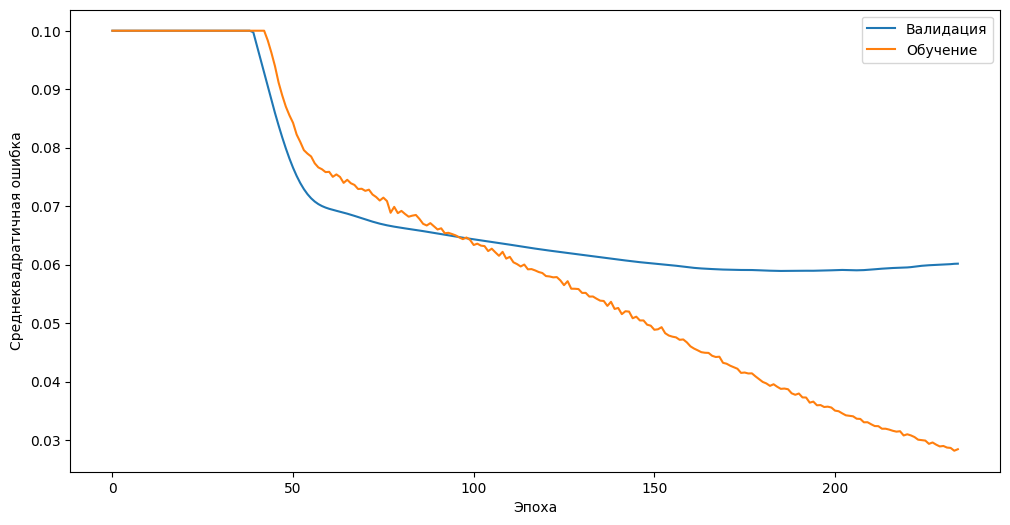

In [ ]:
# посмотрим, подробнее как обучается лучшая модель:
best_losses, best_mses = train_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, best_params)

plt.figure(figsize=(12, 6))

# для удобной визуализации
plt.plot(np.clip(best_mses, 0, 0.1), label='Валидация')
plt.plot(np.clip(best_losses, 0, 0.1), label='Обучение')

plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

In [ ]:
# Создание экземпляра EarlyStopping
early_stopping = EarlyStopping(patience=50, delta=0.0001)

# Создание и обучение модели с лучшими параметрами
best_model = Net(**best_params)
best_optimizer = Adam(best_model.parameters(), lr=best_params['learning_rate'])
best_loss_fn = nn.MSELoss()

for epoch in tqdm(range(num_epochs)):
    best_model.train()
    best_optimizer.zero_grad()

    preds = best_model.forward(X_train_tensor).flatten()

    loss_value = best_loss_fn(preds, y_train_tensor)

    l1_alpha = torch.tensor(best_params['l1_alpha']) if best_params['l1_alpha'] is not None else None
    l1 = best_model.compute_l1_loss()

    if l1_alpha is not None:
        loss_value += l1_alpha * l1

    loss_value.backward()
    best_optimizer.step()

    # Оценка на валидационном наборе данных
    best_model.eval()
    val_preds = best_model.forward(X_val_tensor)
    mse = mean_squared_error(val_preds.flatten().detach().numpy(), y_val_tensor.numpy())

    # Вывод значения MSE на каждой эпохе
    print(f"Epoch: {epoch + 1}/{num_epochs}, MSE: {mse}")

    # Обновление EarlyStopping
    early_stopping(mse)

    if early_stopping.early_stop:
        print(f"Early stopping, MSE: {mse}")
        break

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1/2500, MSE: 0.14688770473003387
Epoch: 2/2500, MSE: 0.14638040959835052
Epoch: 3/2500, MSE: 0.14587560296058655
Epoch: 4/2500, MSE: 0.14537031948566437
Epoch: 5/2500, MSE: 0.14486083388328552
Epoch: 6/2500, MSE: 0.14434653520584106
Epoch: 7/2500, MSE: 0.14382518827915192
Epoch: 8/2500, MSE: 0.14329278469085693
Epoch: 9/2500, MSE: 0.14274759590625763
Epoch: 10/2500, MSE: 0.14218764007091522
Epoch: 11/2500, MSE: 0.14161176979541779
Epoch: 12/2500, MSE: 0.1410180926322937
Epoch: 13/2500, MSE: 0.14040420949459076
Epoch: 14/2500, MSE: 0.13977013528347015
Epoch: 15/2500, MSE: 0.13911300897598267
Epoch: 16/2500, MSE: 0.13843393325805664
Epoch: 17/2500, MSE: 0.1377306878566742
Epoch: 18/2500, MSE: 0.1369992345571518
Epoch: 19/2500, MSE: 0.13623692095279694
Epoch: 20/2500, MSE: 0.13544218242168427
Epoch: 21/2500, MSE: 0.1346118450164795
Epoch: 22/2500, MSE: 0.13374191522598267
Epoch: 23/2500, MSE: 0.13282877206802368
Epoch: 24/2500, MSE: 0.13187041878700256
Epoch: 25/2500, MSE: 0.130864

*В результате подбора параметров MSE достигло 0.058. Можно тестировать модель!*

# Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
queries = pd.read_csv(os.path.join(main_path, 'test_queries.csv'), sep='|')

vec_img_test = list()

for i in tqdm(range(len(queries.image)), leave=False):
    img_path = os.path.join(main_path, 'test_images/', queries.loc[i]['image'])
    img = Image.open(img_path).convert('RGB')
    image_tensor = transformer(img).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    vec_img_test.append(output_tensor)

vectorized_images_test = torch.stack(vec_img_test)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
def research_best_photo(text_to_search):
    print('Описание:', text_to_search)
    if filter_text(text_to_search):
        return print("Предупреждение: This image is unavailable in your country in compliance with local laws \n")

    # Векторизация текста
    tokenized_text_test = tokenizer.encode(text_to_search, add_special_tokens=True)
    padded_test = torch.from_numpy(np.array([tokenized_text_test + [0]*(200 - len(tokenized_text_test))]))
    attention_mask_test = torch.from_numpy(np.where(padded_test != 0, 1, 0))
    with torch.no_grad():
        embeddings = bert_model(padded_test, attention_mask=attention_mask_test)
        vect_text = embeddings[0][:, 0, :].detach().numpy().flatten()

    n = len(vectorized_images_test)  # предполагая, что у вас есть переменная vectorized_images_test с количеством записей
    vect_text_df = pd.DataFrame(np.repeat(vect_text.reshape(1, -1), n, axis=0))
    vect_text_arr = vect_text_df.values

    # Объединение векторов текста и изображений
    image_and_text_features = np.concatenate((vectorized_images_test.numpy(), vect_text_arr), axis=1)
    image_and_text_features = scaler.transform(image_and_text_features)

    # Передача данных в нейросеть для получения предсказаний
    best_model.eval()
    with torch.no_grad():
        input_tensor = torch.from_numpy(image_and_text_features).float()  # Преобразуйте входные данные в тензор PyTorch
        predictions = best_model(input_tensor)  # Получите предсказания от нейросети

    # Получение наилучшего индекса и изображения на основе предсказаний
    best_index = np.argmax(predictions.numpy())
    best_image = queries.loc[best_index]['image']

    # Инициализация загрузчика изображения
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    img = Image.open(os.path.join(main_path, 'test_images', best_image))
    img_tensor = transform(img)
    plt.imshow(img)
    plt.title(f'Вероятность соответствия: {round(predictions.max().item(), 3)}')
    plt.axis('off')
    plt.show()

Описание: A woman sitting at a sewing machine looks up .


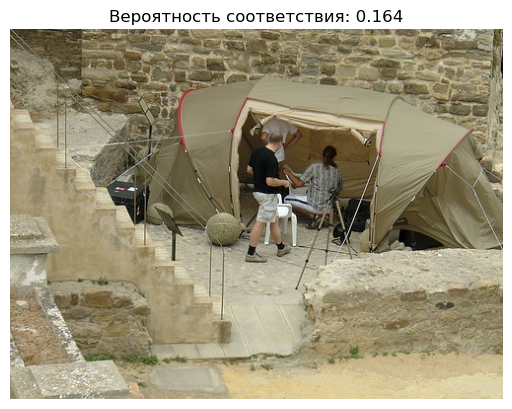

Описание: A group of people perform together onstage .


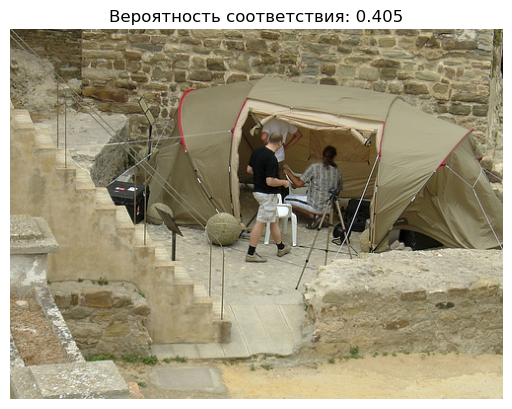

Описание: A woman and a girl ride a sled down a hill standing up .
Предупреждение: This image is unavailable in your country in compliance with local laws 

Описание: Two people are running at the top of a mountain .


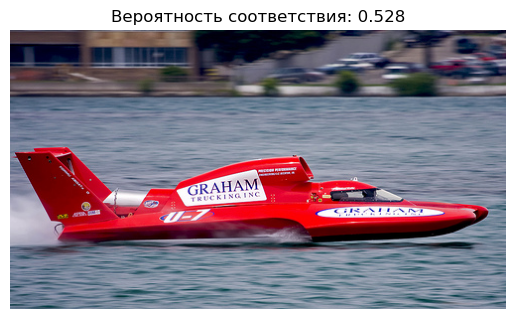

Описание: Cyclists are leaping into the air whilst being watched by spectators .


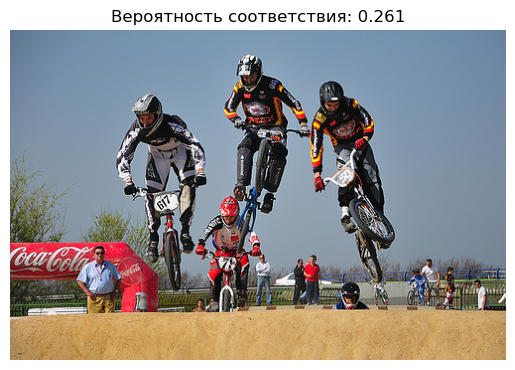

Описание: kids are playing in water fountains
Предупреждение: This image is unavailable in your country in compliance with local laws 

Описание: Stretched image of a brown dog with a white patch of fur in his chest area sitting in the grass with trees in the background .


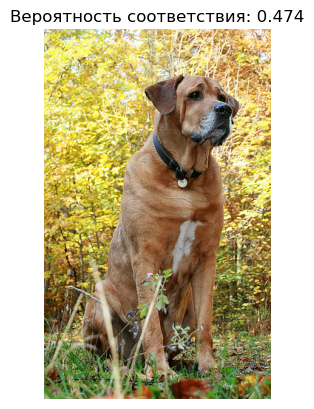

Описание: Two children play with a white dog .
Предупреждение: This image is unavailable in your country in compliance with local laws 

Описание: Young boys enjoying a spray of water .
Предупреждение: This image is unavailable in your country in compliance with local laws 

Описание: A little kid holds up a remote control in front of the television .
Предупреждение: This image is unavailable in your country in compliance with local laws 



In [ ]:
for text in queries.sample(10).query_text:
    research_best_photo(text)